In [1]:
import os
import sys
sys.path.insert(0,os.path.join('/project/venv/lib/python3.8/site-packages/'))
sys.path.insert(0,os.path.join('/venv/lib/python3.8/site-packages'))

def ignore_user_installs(username):
    ## avoid using user installs
    user_install_path = '/scratch/' + username + '/python/lib/python3.8/site-packages'
    if user_install_path in sys.path:
        sys.path.remove(user_install_path)

ignore_user_installs("starzew")

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import scipy
from itertools import combinations
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np

from scipy.stats import rankdata, kendalltau

In [3]:
def load_pkl(file_name):
    with open(file_name, 'rb') as inp:
        data = dill.load(inp)
        
    return data

In [4]:
ds_final = load_pkl("datasets/final.pkl")

In [68]:
def plot_layer_ca_more(layer_cas, title):
    sev = ["v_l","l","m","h","all","c"]
    fs = 13
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, ax = plt.subplots(6,2, sharex="col", sharey=True)
    fig.set_figwidth(480*px)
    fig.set_figheight(6)
    n_layers=6
    colors = mpl.colormaps['tab10'].colors
    palette = {
        0:colors[0],
        1:colors[1],
        2:colors[2],
        3:colors[3],
        4:colors[4],
        5:colors[5]
    }
    offsets = [-0.45,-0.3,-0.15,0,0.15,0.3]
    for l,layer_ca in enumerate(layer_cas):
        d = pd.DataFrame({'L0': layer_ca[0],
                         'L1': layer_ca[1],
                         'L2': layer_ca[2],
                         'L3': layer_ca[3],
                         'L4': layer_ca[4],
                         'L5': layer_ca[5],})
        dlong = d.melt(var_name='layer', value_name="value")
        dlong["variant"] = np.repeat(l,len(dlong))
        dlong["Bins"] = np.concatenate([np.repeat(range(50),30) for _ in range(n_layers)])
        
        for i, layer in enumerate(['L0', 'L1', 'L2', 'L3', 'L4', 'L5']):
            pos = np.arange(50)+offsets[l]
            sns.boxplot(data=dlong[dlong['layer'] == layer], x="Bins", y='value', hue="variant", palette=palette, widths=0.1,capwidths=0.1, positions=pos, ax=ax[i][0],showfliers=False)
            sns.boxplot(data=dlong[dlong['layer'] == layer], x="Bins", y='value', hue="variant", palette=palette, widths=0.1,capwidths=0.1,positions=pos,ax=ax[i][1], showfliers=False)
            ax[i][1].set_xlim(43.6,49.4)
            ax[i][0].set_xlim(-0.6,5.4)
            ax[i][0].set_ylabel(r"$\overline{C}$" + " L" + str(i+1), fontsize=fs)
            ax[i][0].tick_params(axis ='both', which ='major', labelsize = fs)
            ax[i][1].tick_params(axis ='both', which ='major', labelsize = fs)
            ax[i][0].set_xlabel("Bins", fontsize=fs)
            ax[i][1].set_xlabel("Bins", fontsize=fs)
            if i == 0:
                handles, labels = ax[i][0].get_legend_handles_labels()
                ax[i][0].get_legend().remove()
                #ax[i][0].legend(handles, sevs,fontsize=fs,loc='upper center',bbox_transform = plt.gcf().transFigure, bbox_to_anchor=(0.6, 1), ncols=6)
            else:
                ax[i][0].get_legend().remove()
            ax[i][1].get_legend().remove()
      
    fig.align_labels()
    plt.subplots_adjust(hspace=0.15,wspace=0.1,right=0.95)
    fig.legend(handles, sevs,fontsize=fs,loc='upper center',bbox_transform = plt.gcf().transFigure, bbox_to_anchor=(0.525, 0.975), ncols=6)
    plt.savefig(f"figs/{title}.pdf", bbox_inches="tight")
    plt.show()


In [62]:
def convert_cas(layer_ca):
    data = []
    for layer in range(6):
        data.append(np.mean(layer_ca[layer], axis=-1))
    data = np.array(data)
    
    return data

def plot_layer_ca_comparison(layer_cas, given_labels):
    n_layers=6
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, ax = plt.subplots(nrows=n_layers, sharex=True)
    fig.set_figwidth(480*px)
    fig.set_figheight(10)  
    fs = 13
    colors = mpl.colormaps['tab10'].colors
    
    offsets = [-0.2,+0.2]
    for l,layer_ca in enumerate(layer_cas):
        d = pd.DataFrame({'L0': layer_ca[0],
                         'L1': layer_ca[1],
                         'L2': layer_ca[2],
                         'L3': layer_ca[3],
                         'L4': layer_ca[4],
                         'L5': layer_ca[5],})
        dlong = d.melt(var_name='layer', value_name="value")
        dlong["variant"] = np.repeat(l,len(dlong))
        dlong["bins"] = np.concatenate([np.repeat(range(50),30) for _ in range(n_layers)])
        
        
        #ax.set
        for i, layer in enumerate(['L0', 'L1', 'L2', 'L3', 'L4', 'L5']):
            pos = np.arange(50)+offsets[l]
            sns.boxplot(data=dlong[dlong['layer'] == layer], x="bins", y='value', hue="variant", palette={0:colors[0], 1:colors[1]}, widths=0.3, capwidths=0.3, positions=pos, ax=ax[i], showfliers=False)
            num = 5  # Keeps every 7th label
            [lab.set_visible(False) for (j,lab) in enumerate(ax[i].xaxis.get_ticklabels()) if j % num != 0]
            ax[i].set_ylabel(r"$\overline{C}$" + " Layer " + str(i+1))
            ax[i].set_xlim(-0.9,49.9)
            if i == 0:
                handles, labels = ax[i].get_legend_handles_labels()
                ax[i].legend(handles, given_labels,fontsize=fs,loc='upper center', bbox_to_anchor=(0.5, 1.5), ncols=2)
            else:
                ax[i].get_legend().remove()
    fig.align_labels()        
    plt.tight_layout()
    plt.show()

In [7]:
   
def load_cumatts(sevs):
    layer_ca_pt = dict()
    layer_ca_ft = dict()
    
    for sev in sevs:
        layer_ca_pt[sev] = load_pkl(f'cumatt/final_{sev}_pt.pkl')
        layer_ca_ft[sev] = load_pkl(f'cumatt/final_{sev}_ft.pkl')
    
    return layer_ca_pt, layer_ca_ft

In [67]:
def plot_layer_ca_new(layer_ca, mean, title):
    fs = 13
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, ax = plt.subplots(6,1, sharex=True)
    fig.set_figwidth(480*px)
    fig.set_figheight(10)
    colors = mpl.colormaps['tab10'].colors
    for layer in range(6):
        if mean:
            ca = np.mean(layer_ca[layer], axis=-1)
        else:
            ca = layer_ca[layer]
        data = []
        for i in range(50):
            d = ca[i*30:(i+1)*30]
            data.append(d)
        data = np.array(data).transpose()
        
        #plt.subplot(6,1,layer+1)
        sns.boxplot(data=data, ax=ax[layer], width=0.6, showfliers=False, color=colors[0])
        ax[layer].tick_params(axis='both', which='major', labelsize=fs)
        ax[layer].set_xlim(-0.9,49.9)
        ax[layer].set_ylabel(r"$\overline{C}$" + " Layer " + str(layer+1))
        
        n = 5  # Keeps every 7th label
        [l.set_visible(False) for (i,l) in enumerate(ax[layer].xaxis.get_ticklabels()) if i % n != 0]
        
        if layer == 5:
            ax[layer].set_xlabel("Bins", fontsize=fs)
    
    #plt.suptitle(title, fontsize=fs+2)
    plt.subplots_adjust(hspace=0.15,wspace=0.1,right=0.95)
    #plt.tight_layout()
    fig.align_labels()
    plt.savefig(f"figs/{title}.pdf", bbox_inches="tight")
    plt.show()

In [9]:
def plot_cumatt_sample(layer_ca, sample):
    plt.figure(figsize=(15,8))
    fs = 13
    for layer in range(6):
    
        plt.subplot(2,3,layer+1)
        plt.plot(layer_ca[layer,:,sample])
        plt.xlabel("Frame", fontsize=fs)
        plt.xticks(fontsize=fs)
        plt.ylabel("Cumulative Attention", fontsize=fs)
        plt.yticks(fontsize=fs)
        plt.title(f"Layer {layer}", fontsize=fs)
    plt.tight_layout()
    plt.show()

In [10]:
sevs = ["v_l", "l", "m", "h", "all", "c"]
layer_ca_pt, layer_ca_ft = load_cumatts(sevs)

# Temporal Attention for an Intelligibility

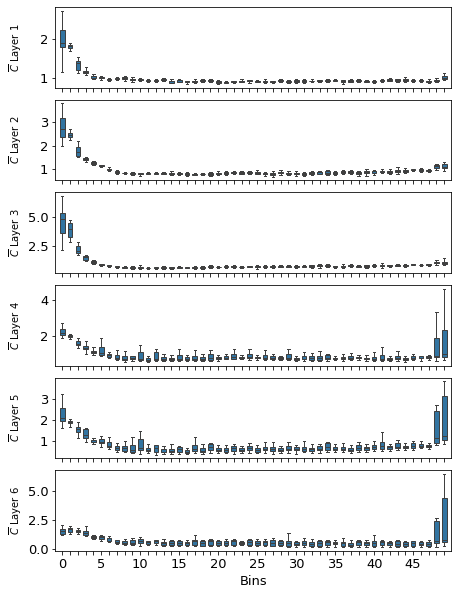

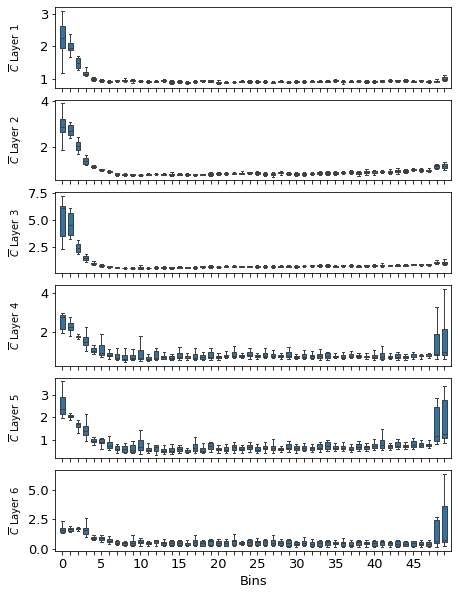

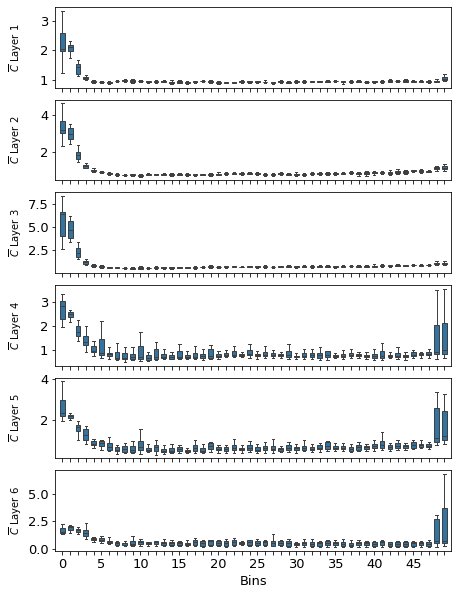

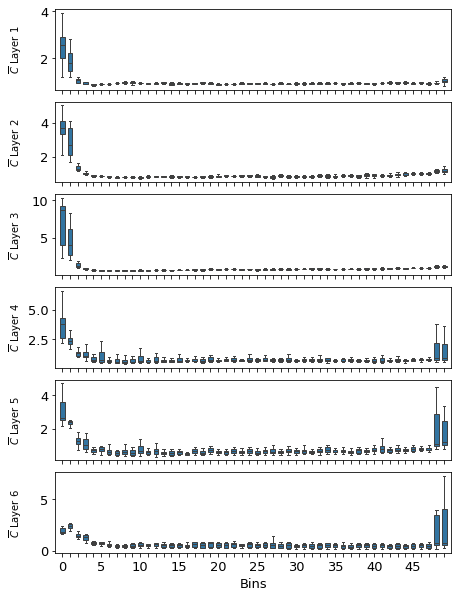

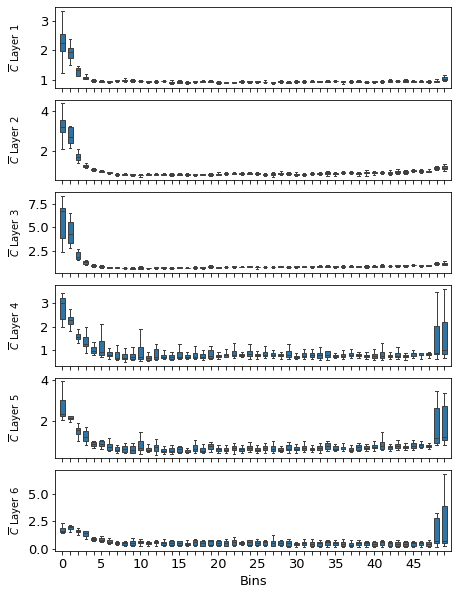

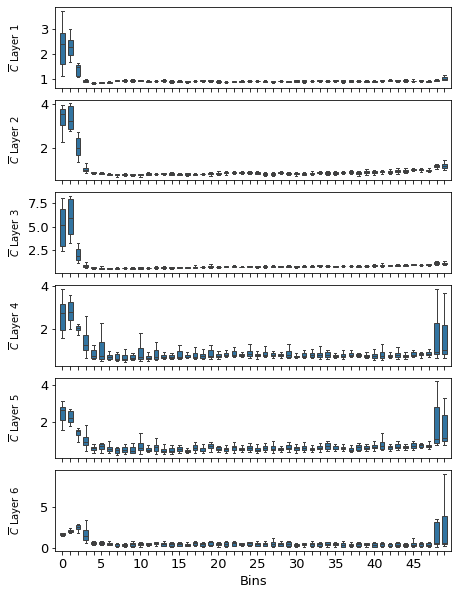

In [54]:
sevs = ["v_l", "l", "m","h", "all", "c"]
for sev in sevs:
    plot_layer_ca_new(layer_ca_pt[sev],mean="True",title= f"layer_ca_{sev}")

# Comparison of Temporal Attention Between PT&FT: 1 Sev

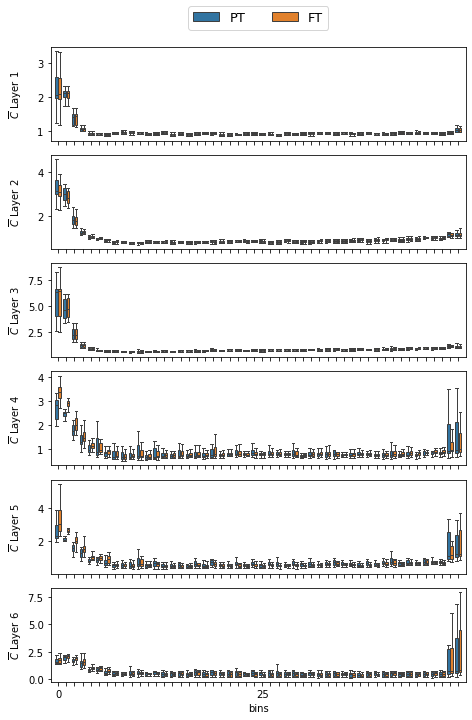

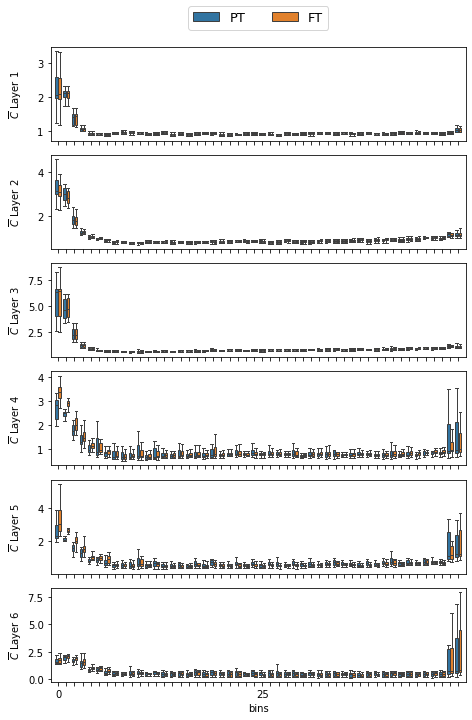

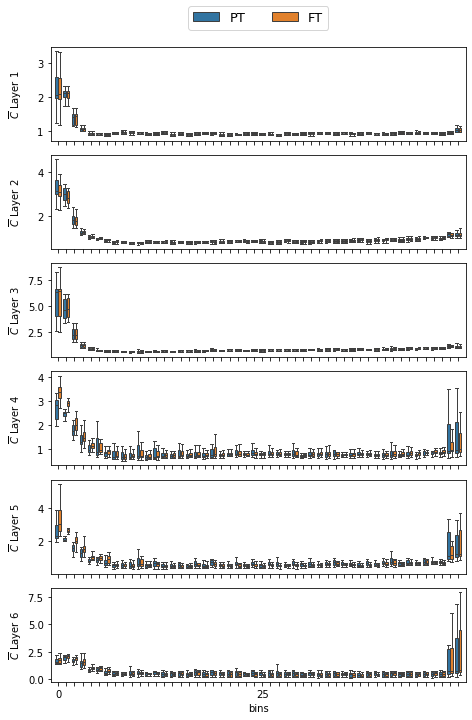

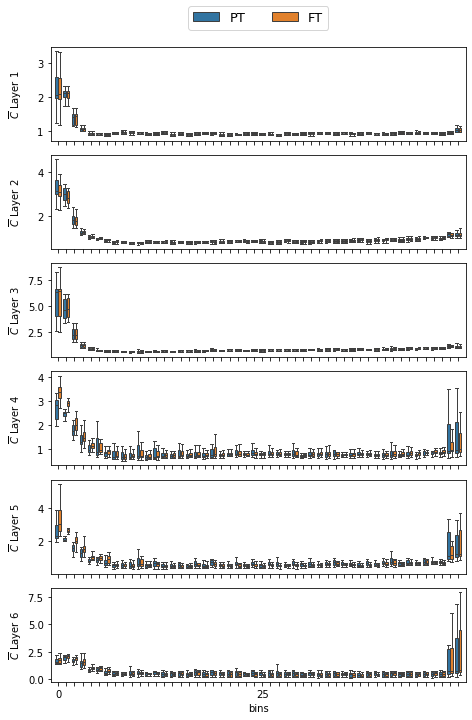

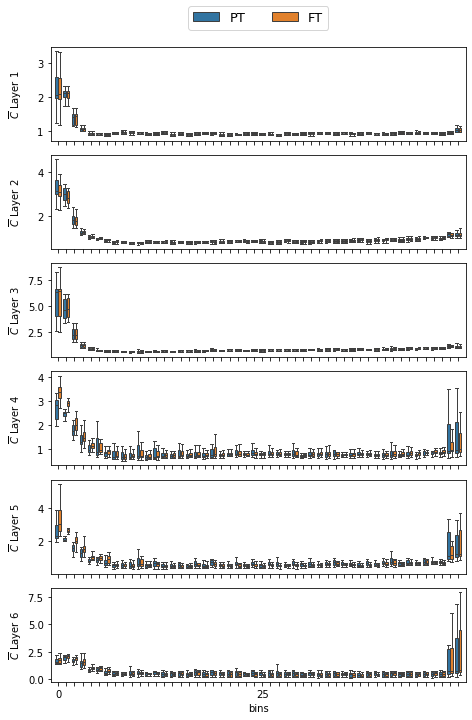

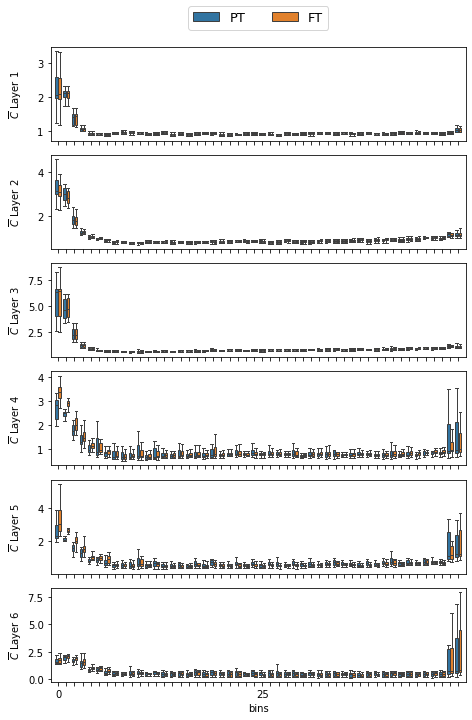

In [63]:
sevs = ["v_l", "l", "m","h", "all", "c"]
labels = ["PT", "FT"]

for sev in sevs:
    layer_cas = [convert_cas(layer_ca_pt["m"]), convert_cas(layer_ca_ft["m"])] 
    plot_layer_ca_comparison(layer_cas,labels)

# Comparison of Sevs: First and Last 6 Bins

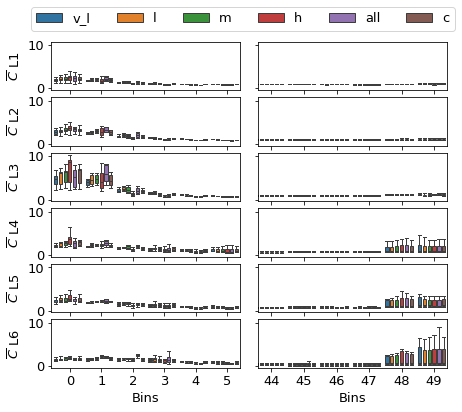

In [69]:
layer_cas = [convert_cas(layer_ca_pt["v_l"]), convert_cas(layer_ca_pt["l"]), convert_cas(layer_ca_pt["m"]),convert_cas(layer_ca_pt["h"]), convert_cas(layer_ca_pt["c"]),convert_cas(layer_ca_pt["all"])]
title="ca_comp_pt"
plot_layer_ca_more(layer_cas, title)

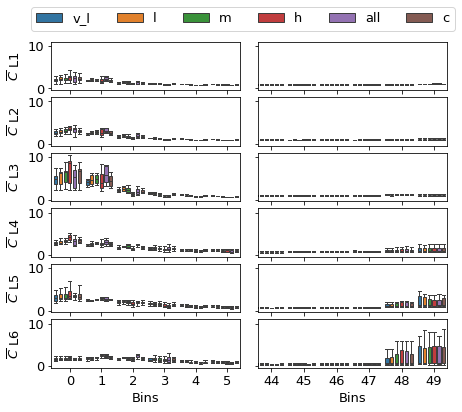

In [70]:
layer_cas = [convert_cas(layer_ca_ft["v_l"]), convert_cas(layer_ca_ft["l"]), convert_cas(layer_ca_ft["m"]),convert_cas(layer_ca_ft["h"]), convert_cas(layer_ca_ft["c"]),convert_cas(layer_ca_ft["all"])]
title="ca_comp_ft"
plot_layer_ca_more(layer_cas,title)

## Ranking

In [76]:
def calc_taus_layer_cas(layer_cas):
    taus_layerwise = []
    og = [1,2,3,4,5]
    for layer in range(6):
        taus = []
        for frame in range(1500):
            tau = kendalltau(rankdata(layer_cas[:,layer,:][:,frame],axis=0), og)
            taus.append(tau[0])

        taus = np.array(taus)
        taus_layerwise.append(taus)

    taus_layerwise = np.array(taus_layerwise)
    taus_layerwise = np.transpose(taus_layerwise)

    avg_taus = np.mean(taus_layerwise,axis=-1)
    
    return avg_taus

In [82]:
def plot_kendalltaus(kendalltaus,kendalltaus_diffs,title):
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, ax = plt.subplots(2,2,sharex="col",sharey=True)
    fig.set_figheight(3)
    fig.set_figwidth(480*px)
    fs = 13
    
    for i, taus in enumerate([kendalltaus,kendalltaus_diffs]):

        ax[i][0].plot(taus)
        ax[i][1].plot(taus)
        ax[i][0].plot(np.repeat([0],1800))
        ax[i][1].plot(np.repeat([0],1800))

        a = 0
        b = 6*30
        c = 45*30
        d = 50*30

        ax[i][0].set_xlim(a,b)
        ax[i][1].set_xlim(c,d)

        ax[i][0].spines["right"].set_visible(False)
        ax[i][1].spines["left"].set_visible(False)
        ax[i][1].yaxis.tick_right()

        d = .015 # how big to make the diagonal lines in axes coordinates
        kwargs = dict(transform=ax[i][0].transAxes, color='k', clip_on=False)
        ax[i][0].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[i][0].plot((1-d,1+d),(1-d,1+d), **kwargs)

        kwargs.update(transform=ax[i][1].transAxes)
        ax[i][1].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[i][1].plot((-d,+d), (-d,+d), **kwargs)

        

        for a in ax[i]:
            a.tick_params(axis='both', which='major', labelsize=fs)

    fig.supxlabel("Frame",x=0.53,fontsize=fs)
    fig.supylabel("Kendall's Tau",y=0.6, fontsize=fs)
    fig.text(0.5, 1, r"$\overline{C}$" + " PT", fontsize=fs)
    fig.text(0.45, 0.57, r"$\overline{C}$" +  " PT vs. FT",fontsize=fs)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.savefig(f"figs/{title}.pdf",bbox_inches="tight")
    plt.show()

In [77]:
layer_cas = [convert_cas(layer_ca_pt["v_l"]), convert_cas(layer_ca_pt["l"]), convert_cas(layer_ca_pt["m"]),convert_cas(layer_ca_pt["h"]), convert_cas(layer_ca_pt["c"])]
layer_cas = np.array(layer_cas)
avg_taus = calc_taus_layer_cas(layer_cas)

In [78]:
layer_cas_pt = [convert_cas(layer_ca_pt["v_l"]), convert_cas(layer_ca_pt["l"]), convert_cas(layer_ca_pt["m"]),convert_cas(layer_ca_pt["h"]), convert_cas(layer_ca_pt["c"])]
layer_cas_ft = [convert_cas(layer_ca_ft["v_l"]), convert_cas(layer_ca_ft["l"]), convert_cas(layer_ca_ft["m"]),convert_cas(layer_ca_ft["h"]), convert_cas(layer_ca_ft["c"])]
diffs = np.array(layer_cas_ft) - np.array(layer_cas_pt)
avg_taus_diffs = calc_taus_layer_cas(diffs)

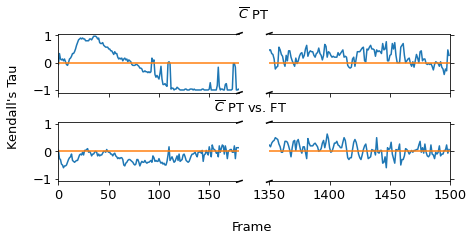

In [83]:
plot_kendalltaus(avg_taus,avg_taus_diffs,"ca_ranking")

# Comparison of Sevs Between PT and FT: First and Last 6 Bins

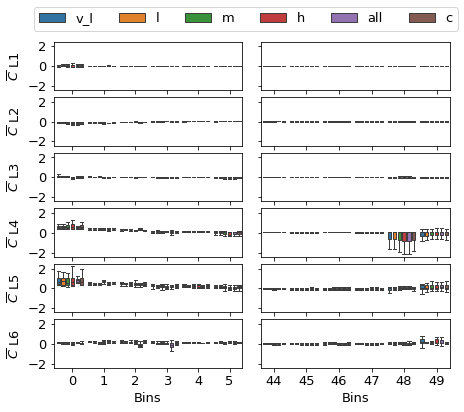

In [84]:
layer_cas_pt = [convert_cas(layer_ca_pt["v_l"]), convert_cas(layer_ca_pt["l"]), convert_cas(layer_ca_pt["m"]),convert_cas(layer_ca_pt["h"]), convert_cas(layer_ca_pt["c"]),convert_cas(layer_ca_pt["all"])]
layer_cas_ft = [convert_cas(layer_ca_ft["v_l"]), convert_cas(layer_ca_ft["l"]), convert_cas(layer_ca_ft["m"]),convert_cas(layer_ca_ft["h"]), convert_cas(layer_ca_ft["c"]),convert_cas(layer_ca_ft["all"])]
diffs = np.array(layer_cas_ft) - np.array(layer_cas_pt)

title="ca_comp_ptft"
plot_layer_ca_more(diffs,title)